In [ ]:
from google.colab import files
uploaded = files.upload()

Saving training_data_expense_forecast.csv to training_data_expense_forecast.csv


In [ ]:
import pandas as pd

# Load the uploaded CSV
df = pd.read_csv('training_data_expense_forecast.csv')

# Preview the data
df.head()


,company_id,group_name,account_name,date,debit_amount,credit
0,7S4LET,Operations,Bank Service Charges,22-03-2022,1880.722981,406.0
1,7S4LET,Ungrouped,Rent,27-10-2022,2104.209501,NaN
2,7S4LET,HR,Miscellaneous Income,28-12-2022,4992.755927,NaN
3,7S4LET,HR,FX Gain/ Loss,19-11-2023,476.002770,NaN
4,7S4LET,Operations,Miscellaneous Expense,20-10-2022,3320.140989,NaN


In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split

# Load the CSV
df = pd.read_csv('training_data_expense_forecast.csv')

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

# Ensure numeric values and fill NaNs
df['debit_amount'] = pd.to_numeric(df['debit_amount'], errors='coerce').fillna(0)
df['credit'] = pd.to_numeric(df['credit'], errors='coerce').fillna(0)

# Subtract credit from debit to get actual spending
df['net_expense'] = df['debit_amount'] - df['credit']

# Set the date as the index
df.set_index('date', inplace=True)

# Resample to monthly sums
monthly_expense = df['net_expense'].resample('M').sum()

# Train-test split (e.g., 80% train, 20% test)
split_index = int(len(monthly_expense) * 0.8)
train_data = monthly_expense[:split_index]
test_data = monthly_expense[split_index:]

# ADF test on the training set
result = adfuller(train_data)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
df.head()


ADF Statistic: -3.7616905523859843
p-value: 0.003324510832136397


<ipython-input-4-a01ec59a1deb>:9: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['date'] = pd.to_datetime(df['date'])
<ipython-input-4-a01ec59a1deb>:22: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_expense = df['net_expense'].resample('M').sum()


,company_id,group_name,account_name,debit_amount,credit,net_expense
date,,,,,,
2022-03-22,7S4LET,Operations,Bank Service Charges,1880.722981,406.0,1474.722981
2022-10-27,7S4LET,Ungrouped,Rent,2104.209501,0.0,2104.209501
2022-12-28,7S4LET,HR,Miscellaneous Income,4992.755927,0.0,4992.755927
2023-11-19,7S4LET,HR,FX Gain/ Loss,476.002770,0.0,476.002770
2022-10-20,7S4LET,Operations,Miscellaneous Expense,3320.140989,0.0,3320.140989


In [ ]:
df = df[df['net_expense'] >= 0]


In [ ]:
from scipy.stats import zscore
df['z'] = zscore(df['net_expense'])
df = df[df['z'].abs() < 3]  # Keep only values within 3 standard deviations
df.drop(columns='z', inplace=True)


In [ ]:
!pip uninstall -y numpy pmdarima
!pip install numpy==1.24.4 pmdarima==2.0.4 --no-cache-dir


Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 259.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 288.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.4 which is incompatible.
pymc 5.21.2 requires numpy>=1.25.0, but you have numpy 1.24.4 which is incompatible.
blosc2 3.3.1 requires numpy>=1.26, but you have numpy 1.24.4 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.4 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima

Augmented Dickey-Fuller Test (ADF) to check stationarity:

If p-value > 0.05 ➜ Not stationary → needs differencing

If p-value < 0.05 ➜ Stationary → you're good to go

<ipython-input-2-8095f32c5864>:2: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('training_data_expense_forecast.csv', parse_dates=['date'])
<ipython-input-2-8095f32c5864>:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_expense = df['net_expense'].resample('M').sum()


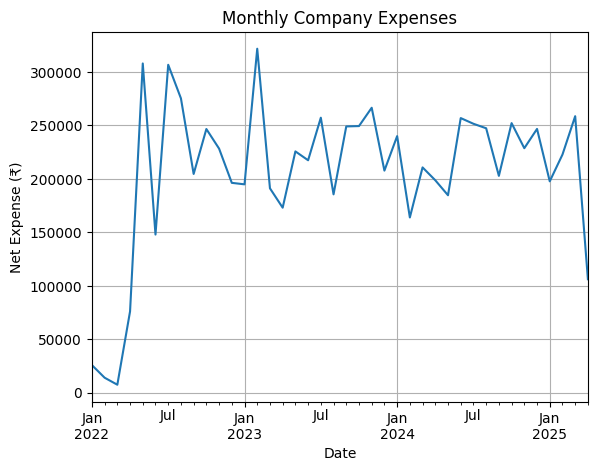

ADF Statistic: -3.7616905523859843
p-value: 0.003324510832136397
Performing stepwise search to minimize aic


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.28 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=815.287, Time=0.04 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=811.925, Time=0.30 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=845.073, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=879.537, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=810.177, Time=0.07 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=812.152, Time=0.17 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=813.721, Time=0.25 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=814.358, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=833.080, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=843.097, Time=0.03 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=828.237, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[12]             : AIC=815.688, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 2.527 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   32
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -402.088
Date:                Thu, 24 Apr 2025   AIC                            810.177
Time:                        17:59:34   BIC                            814.574
Sample:                    01-31-2022   HQIC                           811.634
                         - 08-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
# Load and clean data
df = pd.read_csv('training_data_expense_forecast.csv', parse_dates=['date'])
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y', errors='coerce')
df['debit_amount'] = pd.to_numeric(df['debit_amount'], errors='coerce').fillna(0)
df['credit'] = pd.to_numeric(df.get('credit', 0), errors='coerce').fillna(0)

# Compute net expense
df['net_expense'] = df['debit_amount'] - df['credit']

# Set date as index
df.set_index('date', inplace=True)

# Resample to monthly data
monthly_expense = df['net_expense'].resample('M').sum()

# Plot the time series
monthly_expense.plot(title="Monthly Company Expenses")
plt.ylabel("Net Expense (₹)")
plt.xlabel("Date")
plt.grid(True)
plt.show()

# Train-test split (80% train, 20% test)
split_index = int(len(monthly_expense) * 0.8)
train_data = monthly_expense[:split_index]
test_data = monthly_expense[split_index:]

# ADF test on training set
result = adfuller(train_data)
print("ADF Statistic:", result[0])
print("p-value:", result[1])

# Train auto_arima on train_data only
model = auto_arima(
    train_data,
    seasonal=True,
    m=12,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

# Show model summary
print(model.summary())

In [ ]:
import pandas as pd
import numpy as np

# Add date features
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['weekday'] = df.index.weekday
df['quarter'] = df.index.quarter
df['is_month_end'] = df.index.is_month_end
df['is_quarter_end'] = df.index.month.isin([3, 6, 9, 12])
df['is_half_year_end'] = df.index.month.isin([6, 12])
df['is_fy_end'] = df.index.month == 12

# Custom fiscal period
def fiscal_periods(date):
    fiscal_year = date.year
    fiscal_quarter = (date.month - 1) // 3 + 1
    fiscal_half = 1 if date.month <= 6 else 2
    return pd.Series([fiscal_year, fiscal_quarter, fiscal_half], index=['fiscal_year', 'fiscal_quarter', 'fiscal_half'])

df[['fiscal_year', 'fiscal_quarter', 'fiscal_half']] = df.index.to_series().apply(fiscal_periods)

# Add income flag
df['is_income'] = df['credit'] > 0

# Monthly transaction volume
df['transaction_volume'] = 1
# Grouped monthly data
monthly_df = df.groupby([pd.Grouper(freq='MS'), 'group_name', 'account_name']).agg({
    'net_expense': 'sum',
    'transaction_volume': 'sum',
    'is_income': 'sum'
}).reset_index()

# Create a helper to compute rolling + lag
def add_lag_features(group):
    group = group.sort_values('date')  # Ensure sorted by time
    group['lag_1'] = group['net_expense'].shift(1)
    group['lag_2'] = group['net_expense'].shift(2)
    group['rolling_mean_3'] = group['net_expense'].rolling(3).mean()
    group['rolling_std_3'] = group['net_expense'].rolling(3).std()
    return group

# Apply to each group_name + account_name
monthly_df = monthly_df.groupby(['group_name', 'account_name']).apply(add_lag_features).reset_index(drop=True)

<ipython-input-10-4b1bc502226f>:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_df = monthly_df.groupby(['group_name', 'account_name']).apply(add_lag_features).reset_index(drop=True)


📊 1. Net Expense + 3-Month Rolling Mean
What it shows:

Actual monthly spending vs. a smoothed average trend.

Why it’s useful:

Helps identify spikes or dips in expenses.

The rolling mean removes short-term noise → gives a clearer long-term trend.

Management can forecast better and avoid over-reaction to one-off anomalies.

Business use case:

"Why was February 2024's expense 3x the average? Was it an annual license fee? Should we plan for it again next year?"

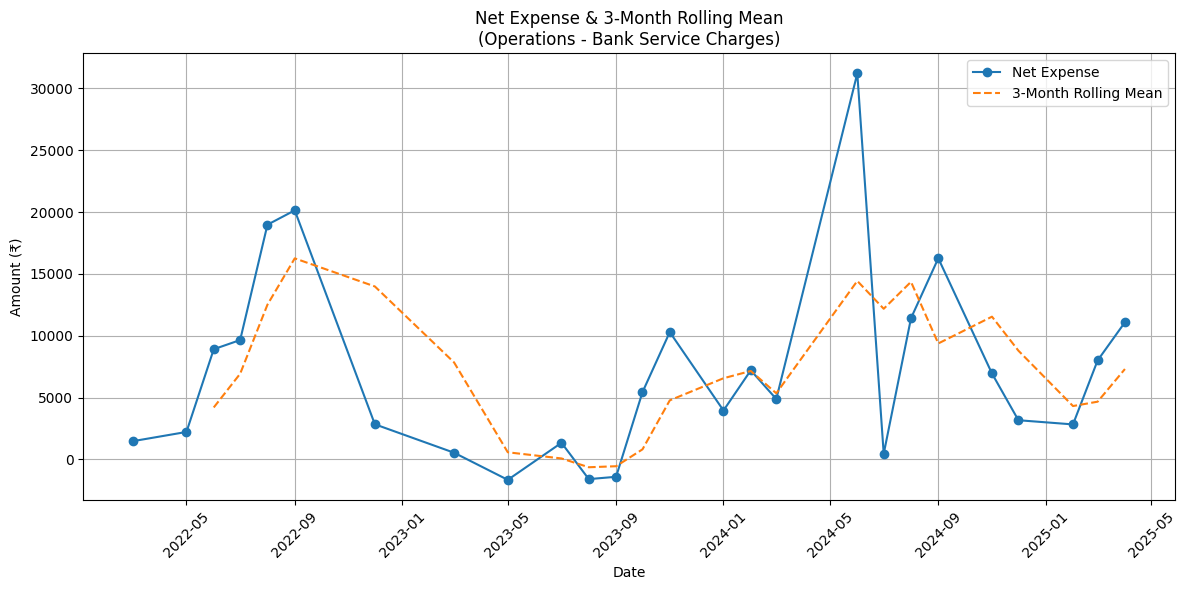

In [ ]:
import matplotlib.pyplot as plt

# Example: Plot for one group_name + account_name
sample_df = monthly_df[(monthly_df['group_name'] == 'Operations') & (monthly_df['account_name'] == 'Bank Service Charges')]

plt.figure(figsize=(12, 6))
plt.plot(sample_df['date'], sample_df['net_expense'], label='Net Expense', marker='o')
plt.plot(sample_df['date'], sample_df['rolling_mean_3'], label='3-Month Rolling Mean', linestyle='--')
plt.title('Net Expense & 3-Month Rolling Mean\n(Operations - Bank Service Charges)')
plt.xlabel('Date')
plt.ylabel('Amount (₹)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


📈 2. Transaction Volume Over Time
What it shows:

Number of individual transactions per month.

Why it’s useful:

Explains sudden cost increases (many small transactions vs. one large).

Flags operational inefficiencies — too many small expenses may need consolidation.

Helpful in fraud detection — unexpected spikes in transaction count can be suspicious.

Business use case:

"April had the same expense as March, but 3x the transactions. Are we splitting purchases unnecessarily?"

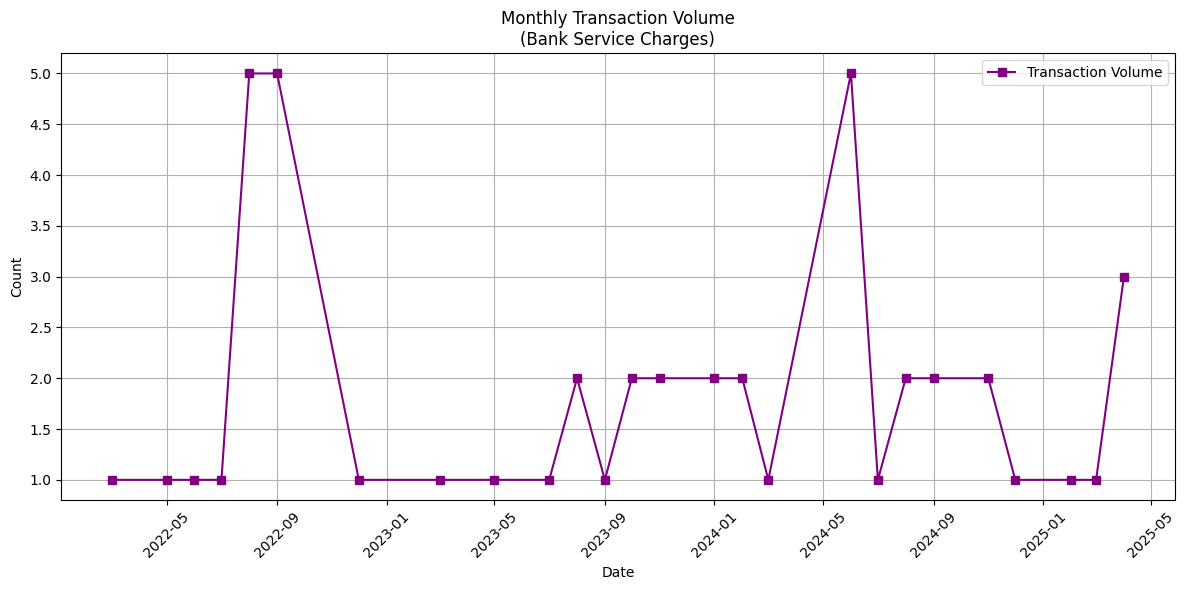

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(sample_df['date'], sample_df['transaction_volume'], label='Transaction Volume', color='purple', marker='s')
plt.title('Monthly Transaction Volume\n(Bank Service Charges)')
plt.xlabel('Date')
plt.ylabel('Count')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


📉 3. Rolling Standard Deviation (Volatility)
What it shows:

Fluctuation level in monthly expenses — higher std dev = less predictable.

Why it’s useful:

Helps assess expense consistency.

Departments with high volatility might need stricter budgets or contingency funds.

Can prioritize risk management.

Business use case:

"HR department expenses are unpredictable. We should consider a buffer or a cap."

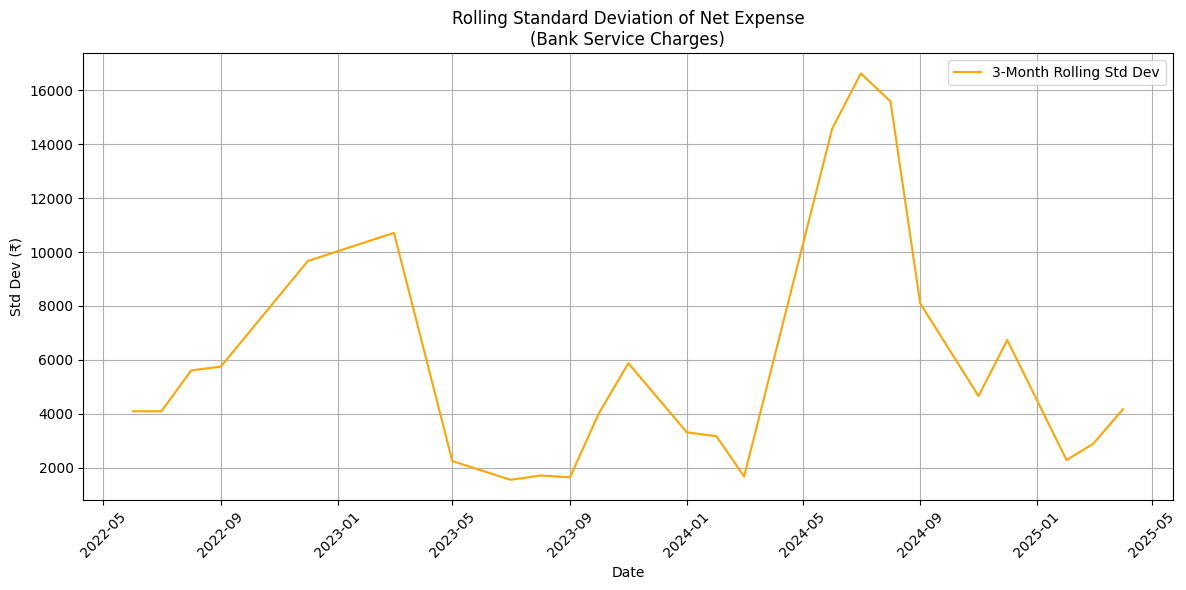

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(sample_df['date'], sample_df['rolling_std_3'], label='3-Month Rolling Std Dev', color='orange')
plt.title('Rolling Standard Deviation of Net Expense\n(Bank Service Charges)')
plt.xlabel('Date')
plt.ylabel('Std Dev (₹)')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


ACF/PACF and trend analysis workflow

In [ ]:
# Example: Filter for "Operations" - "Bank Service Charges"
filtered_df = monthly_df[
    (monthly_df['group_name'] == 'Operations') &
    (monthly_df['account_name'] == 'Bank Service Charges')
].copy()

# Set date as index
filtered_df.set_index('date', inplace=True)

# Make sure index is sorted
filtered_df = filtered_df.sort_index()


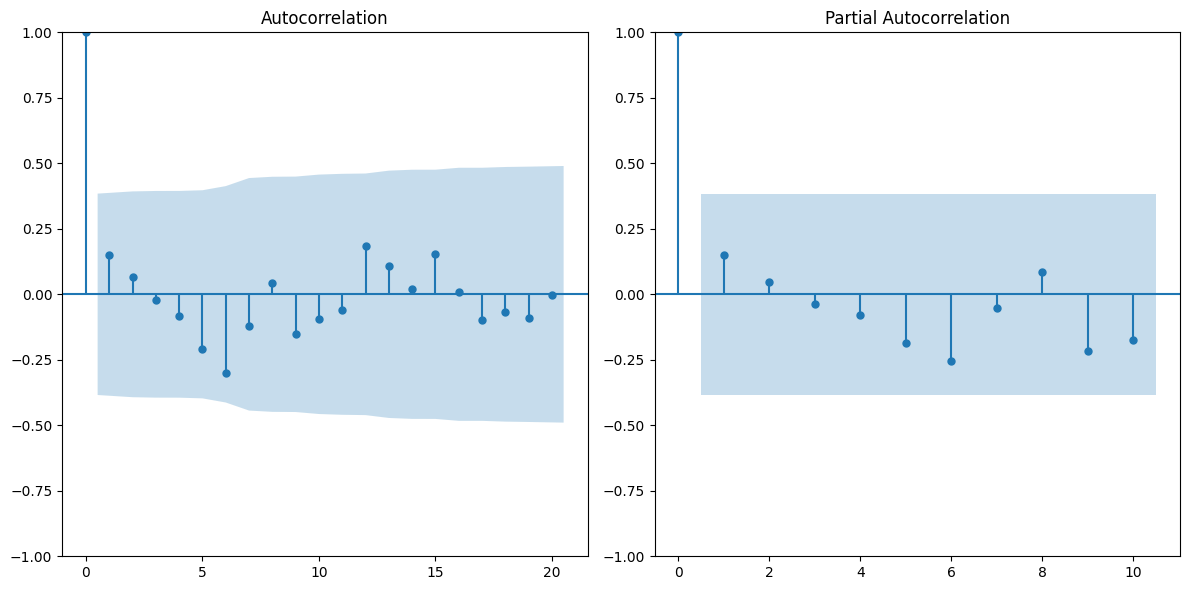

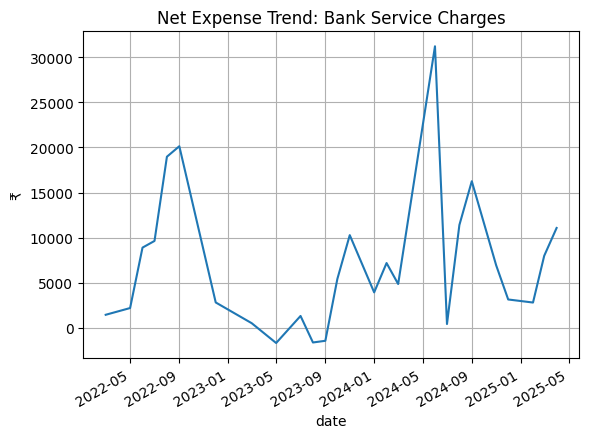

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Check if enough data points
n = len(filtered_df)
if n >= 5:  # ensure you have enough data
    plt.figure(figsize=(12, 6))

    # ACF Plot
    plt.subplot(121)
    plot_acf(filtered_df['net_expense'], ax=plt.gca(), lags=min(n-1, 20))

    # PACF Plot
    plt.subplot(122)
    plot_pacf(filtered_df['net_expense'], ax=plt.gca(), lags=min(n // 2, 10))

    plt.tight_layout()
    plt.show()

    # Trend Line
    filtered_df['net_expense'].plot(title=f"Net Expense Trend: {filtered_df['account_name'].iloc[0]}")
    plt.ylabel("₹")
    plt.grid(True)
    plt.show()
else:
    print("Not enough data points for ACF/PACF.")


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit the SARIMAX model with the chosen parameters
model = SARIMAX(
    filtered_df['net_expense'],
    order=(1, 1, 1),            # ARIMA part (p=1, d=1, q=1)
    seasonal_order=(1, 1, 1, 12) # Seasonal part (P=1, D=1, Q=1, s=12 for yearly seasonality)
)

# Fit the model
results = model.fit()

# Print the model summary
print(results.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization

                                     SARIMAX Results                                      
Dep. Variable:                        net_expense   No. Observations:                   26
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -133.356
Date:                            Thu, 24 Apr 2025   AIC                            276.711
Time:                                    18:37:25   BIC                            279.536
Sample:                                         0   HQIC                           276.131
                                             - 26                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3140      0.705     -0.445      0.656      -1.696       1.068
ma.L1         -0.9740      3.286   

1. Monthly Forecasting (next few months)
You can forecast the next few months by using the forecast function. For example, to forecast the next 3 months:

In [ ]:
# Forecast for the next 3 months
monthly_forecast = results.forecast(steps=1)
print("Monthly Forecast for Next Month:", monthly_forecast)


Monthly Forecast for Next Month: 26    12832.070021
dtype: float64


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


2. Quarterly Forecasting
To forecast for the next quarter (3 months), you can specify steps=3:

In [ ]:
# Quarterly forecast (next 3 months)
quarterly_forecast = results.forecast(steps=3)
print("Quarterly Forecast:", quarterly_forecast)


Quarterly Forecast: 26    12832.070021
27    15113.895308
28    20978.528306
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


3. Half-Yearly Forecasting (Next 6 months)
For half-yearly forecasting, you can forecast for the next 6 months:

In [ ]:
# Half-yearly forecast (next 6 months)
half_yearly_forecast = results.forecast(steps=6)
print("Half-Yearly Forecast:", half_yearly_forecast)


Half-Yearly Forecast: 26    12832.070021
27    15113.895308
28    20978.528306
29    37689.641038
30     5664.729121
31    10598.514243
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


4. Yearly Forecasting (Next 12 months)
For forecasting one year ahead (12 months):

In [ ]:
# Yearly forecast (next 12 months)
yearly_forecast = results.forecast(steps=12)
print("Yearly Forecast:", yearly_forecast)


Yearly Forecast: 26    12832.070021
27    15113.895308
28    20978.528306
29    37689.641038
30     5664.729121
31    10598.514243
32    11837.844380
33     8947.259602
34     3779.417488
35     6003.196171
36    12864.825965
37    17489.678119
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


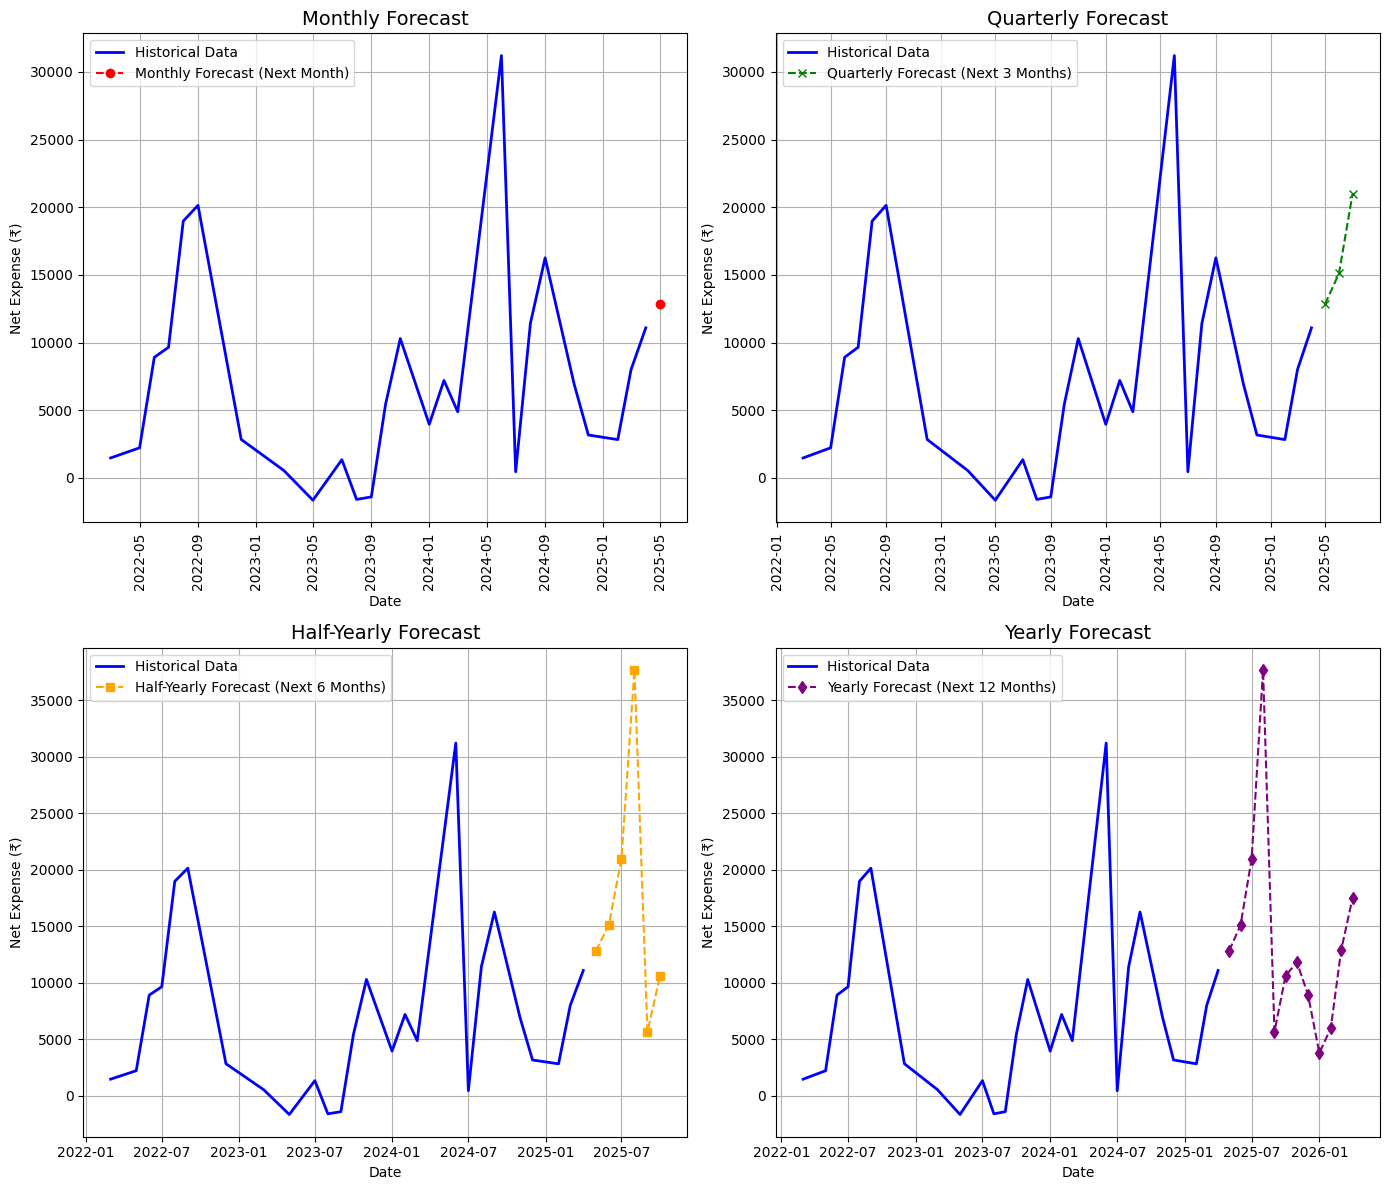

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Create forecast index for each forecast period
forecast_index_monthly = pd.date_range(start=filtered_df.index[-1], periods=2, freq='MS')[1:]
forecast_index_quarterly = pd.date_range(start=filtered_df.index[-1], periods=4, freq='MS')[1:]
forecast_index_half_yearly = pd.date_range(start=filtered_df.index[-1], periods=7, freq='MS')[1:]
forecast_index_yearly = pd.date_range(start=filtered_df.index[-1], periods=13, freq='MS')[1:]

# Plot the detailed visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Monthly Forecast Plot
axes[0, 0].plot(filtered_df.index, filtered_df['net_expense'], label="Historical Data", color='blue', linewidth=2)
axes[0, 0].plot(forecast_index_monthly, monthly_forecast, label="Monthly Forecast (Next Month)", color='red', linestyle='--', marker='o')
axes[0, 0].set_title("Monthly Forecast", fontsize=14)
axes[0, 0].set_xlabel("Date")
axes[0, 0].set_ylabel("Net Expense (₹)")
axes[0, 0].legend()
axes[0, 0].grid(True)
axes[0, 0].tick_params(axis='x', rotation=90)

# Quarterly Forecast Plot
axes[0, 1].plot(filtered_df.index, filtered_df['net_expense'], label="Historical Data", color='blue', linewidth=2)
axes[0, 1].plot(forecast_index_quarterly, quarterly_forecast, label="Quarterly Forecast (Next 3 Months)", color='green', linestyle='--', marker='x')
axes[0, 1].set_title("Quarterly Forecast", fontsize=14)
axes[0, 1].set_xlabel("Date")
axes[0, 1].set_ylabel("Net Expense (₹)")
axes[0, 1].legend()
axes[0, 1].grid(True)
axes[0, 1].tick_params(axis='x', rotation=90)

# Half-Yearly Forecast Plot
axes[1, 0].plot(filtered_df.index, filtered_df['net_expense'], label="Historical Data", color='blue', linewidth=2)
axes[1, 0].plot(forecast_index_half_yearly, half_yearly_forecast, label="Half-Yearly Forecast (Next 6 Months)", color='orange', linestyle='--', marker='s')
axes[1, 0].set_title("Half-Yearly Forecast", fontsize=14)
axes[1, 0].set_xlabel("Date")
axes[1, 0].set_ylabel("Net Expense (₹)")
axes[1, 0].legend()
axes[1, 0].grid(True)
axes[0, 0].tick_params(axis='x', rotation=90)

# Yearly Forecast Plot
axes[1, 1].plot(filtered_df.index, filtered_df['net_expense'], label="Historical Data", color='blue', linewidth=2)
axes[1, 1].plot(forecast_index_yearly, yearly_forecast, label="Yearly Forecast (Next 12 Months)", color='purple', linestyle='--', marker='d')
axes[1, 1].set_title("Yearly Forecast", fontsize=14)
axes[1, 1].set_xlabel("Date")
axes[1, 1].set_ylabel("Net Expense (₹)")
axes[1, 1].legend()
axes[1, 1].grid(True)
axes[0, 0].tick_params(axis='x', rotation=90)

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('training_data_expense_forecast.csv')

# Parse 'date' column to datetime
df['date'] = pd.to_datetime(df['date'], dayfirst=True)

# Set 'date' as the index
df.set_index('date', inplace=True)

# Group by date and sum debit_amount to remove duplicates
df = df.groupby(df.index).agg({'debit_amount': 'sum'})

# Set frequency to month-end
df = df.asfreq('ME')

# Group by month and sum debit_amount (monthly aggregation)
monthly_data = df['debit_amount'].resample('ME').sum().reset_index()

# Sort by date
monthly_data = monthly_data.sort_values('date')

# Split into train (till Feb 2025) and test (March 2025)
train_data = monthly_data[monthly_data['date'] < '2025-03-01']
test_data = monthly_data[monthly_data['date'] == '2025-03-31']

# Set date as index for training
train_data.set_index('date', inplace=True)

# Define SARIMA parameter combinations for grid search
orders = [(1, 1, 1), (2, 1, 1), (1, 1, 2)]
seasonal_orders = [(1, 1, 1, 12), (0, 1, 1, 12), (1, 0, 1, 12)]

best_score = float('inf')
best_model = None

# Loop over parameter combinations to find the best model
for order in orders:
    for seasonal in seasonal_orders:
        try:
            # Fit SARIMAX model
            model = SARIMAX(train_data['debit_amount'], order=order, seasonal_order=seasonal)
            results = model.fit(disp=False)

            # Forecast the next period
            forecast = results.forecast(steps=1)
            forecast_value = forecast.iloc[0]

            # Get actual value from test data
            actual_value = test_data['debit_amount'].values[0]

            # Calculate Mean Absolute Error (MAE) for model comparison
            mae = abs(forecast_value - actual_value)

            if mae < best_score:
                best_score = mae
                best_model = (order, seasonal, forecast_value)

        except Exception as e:
            print(f"Error with model (Order={order}, Seasonal={seasonal}): {e}")
            continue

# Output the best model found
print("Best model:", best_model)

# Forecast using the best model
order, seasonal, forecast_value = best_model

# Fit the best SARIMA model
best_sarima_model = SARIMAX(train_data['debit_amount'], order=order, seasonal_order=seasonal)
best_results = best_sarima_model.fit(disp=False)

# Forecast for March 2025
forecast = best_results.forecast(steps=1)
forecast_value = forecast.iloc[0]

# Get the actual value from the test set
actual_value = test_data['debit_amount'].values[0]

# Calculate difference and accuracy
difference = abs(actual_value - forecast_value)
accuracy = 100 - (difference / actual_value * 100)

# Print the comparison table
print("Period\t\tForecasted Value\tActual Value\t\tDifference\t\tAccuracy %")
print(f"March 2025\t₹{forecast_value:,.2f}\t\t₹{actual_value:,.2f}\t\t₹{difference:,.2f}\t\t{accuracy:.2f}%")


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No freq

Best model: ((1, 1, 2), (0, 1, 1, 12), 5529.173760592302)
Period		Forecasted Value	Actual Value		Difference		Accuracy %
March 2025	₹5,529.17		₹7,331.27		₹1,802.10		75.42%


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load the CSV
df = pd.read_csv('training_data_expense_forecast.csv')

# Convert 'date' to datetime
df['date'] = pd.to_datetime(df['date'], dayfirst=True)

# Group by quarter and sum debit_amount
quarterly_data = df.groupby(pd.Grouper(key='date', freq='Q'))['debit_amount'].sum().reset_index()

# Sort by date
quarterly_data = quarterly_data.sort_values('date')

# Train data: all quarters up to and including Q4 2024 (i.e., before Q1 2025)
train_quarter = quarterly_data[quarterly_data['date'] < '2025-01-01']

# Test data: Q1 2025
test_quarter = quarterly_data[quarterly_data['date'] == '2025-03-31']  # Q1 ends on Mar 31

# Set date index for SARIMAX
train_quarter.set_index('date', inplace=True)

# Fit SARIMAX (quarterly data, so seasonal_order's period=4)
model = SARIMAX(train_quarter['debit_amount'], order=(1,1,1), seasonal_order=(1,1,1,4))
results = model.fit(disp=False)

# Forecast Q1 2025
forecast_q1 = results.forecast(steps=1)
forecast_value = forecast_q1.iloc[0]

# Actual value from test data
actual_value = test_quarter['debit_amount'].values[0]

# Calculate difference and accuracy
difference = abs(actual_value - forecast_value)
accuracy = 100 - (difference / actual_value * 100)

# Print the comparison
print("Period\t\tForecasted Value\tActual Value\t\tDifference\t\tAccuracy %")
print(f"Q1 2025\t\t₹{forecast_value:,.2f}\t\t₹{actual_value:,.2f}\t\t₹{difference:,.2f}\t\t{accuracy:.2f}%")


<ipython-input-75-99f316b1b342>:12: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_data = df.groupby(pd.Grouper(key='date', freq='Q'))['debit_amount'].sum().reset_index()
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Period		Forecasted Value	Actual Value		Difference		Accuracy %
Q1 2025		₹892,468.44		₹757,655.84		₹134,812.60		82.21%


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load the CSV
df = pd.read_csv('training_data_expense_forecast.csv')

# Convert 'date' to datetime
df['date'] = pd.to_datetime(df['date'], dayfirst=True)

# Group by half-year and sum debit_amount
# Custom half-year periods: Jan–Jun (H1), Jul–Dec (H2)
def get_half_year(date):
    return f"H1-{date.year}" if date.month <= 6 else f"H2-{date.year}"

df['half_year'] = df['date'].apply(get_half_year)
half_year_data = df.groupby('half_year')['debit_amount'].sum().reset_index()

# Convert half_year to a proper datetime (we'll use June 30 or Dec 31 for plotting)
half_year_data['date'] = pd.to_datetime(half_year_data['half_year'].str.replace('H1-', '30-06-').str.replace('H2-', '31-12-'), dayfirst=True)

# Sort by date
half_year_data = half_year_data.sort_values('date')

# Train data: all half-years before H1 2025
train_hy = half_year_data[half_year_data['date'] < '2025-01-01']

# Test data: H1 2025
test_hy = half_year_data[half_year_data['half_year'] == 'H1-2025']

# Set date index for training
train_hy.set_index('date', inplace=True)

# Fit SARIMAX (seasonal period = 2 since we have H1 and H2 per year)
model = SARIMAX(train_hy['debit_amount'], order=(1,1,1), seasonal_order=(1,1,1,2))
results = model.fit(disp=False)

# Forecast H1 2025
forecast_h1 = results.forecast(steps=1)
forecast_value = forecast_h1.iloc[0]

# Actual value from test data
actual_value = test_hy['debit_amount'].values[0]

# Calculate difference and accuracy
difference = abs(actual_value - forecast_value)
accuracy = 100 - (difference / actual_value * 100)

# Print the comparison
print("Period\t\tForecasted Value\tActual Value\t\tDifference\t\tAccuracy %")
print(f"H1 2025\t\t₹{forecast_value:,.2f}\t\t₹{actual_value:,.2f}\t\t₹{difference:,.2f}\t\t{accuracy:.2f}%")


Period		Forecasted Value	Actual Value		Difference		Accuracy %
H1 2025		₹1,353,368.82		₹894,369.72		₹458,999.10		48.68%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 2QE-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 2QE-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load and parse data
df = pd.read_csv('training_data_expense_forecast.csv')
df['date'] = pd.to_datetime(df['date'], dayfirst=True)

# Group by year and sum
df['year'] = df['date'].dt.year
yearly_data = df.groupby('year')['debit_amount'].sum().reset_index()

# Separate training (before 2025) and actual for 2025
train_yearly = yearly_data[yearly_data['year'] < 2025]
test_yearly = yearly_data[yearly_data['year'] == 2025]

# Set index to year
train_yearly.set_index('year', inplace=True)

# Fit SARIMAX model (ARIMA(1,0,0) with intercept, no seasonal part)
model = SARIMAX(train_yearly['debit_amount'], order=(0,0,1), trend='c')
results = model.fit(disp=False)

# Forecast for 2025
forecast_2025 = results.forecast(steps=1)
forecast_value = forecast_2025.iloc[0]

# Actual value
actual_value = test_yearly['debit_amount'].values[0]

# Calculate difference and accuracy
difference = abs(actual_value - forecast_value)
accuracy = 100 - (difference / actual_value * 100)

# Print the comparison
print("Period\tForecasted Value\tActual Value\t\tDifference\t\tAccuracy %")
print(f"2025\t₹{forecast_value:,.2f}\t\t₹{actual_value:,.2f}\t\t₹{difference:,.2f}\t\t{accuracy:.2f}%")


Period	Forecasted Value	Actual Value		Difference		Accuracy %
2025	₹1,407,391.21		₹894,369.72		₹513,021.49		42.64%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results w

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


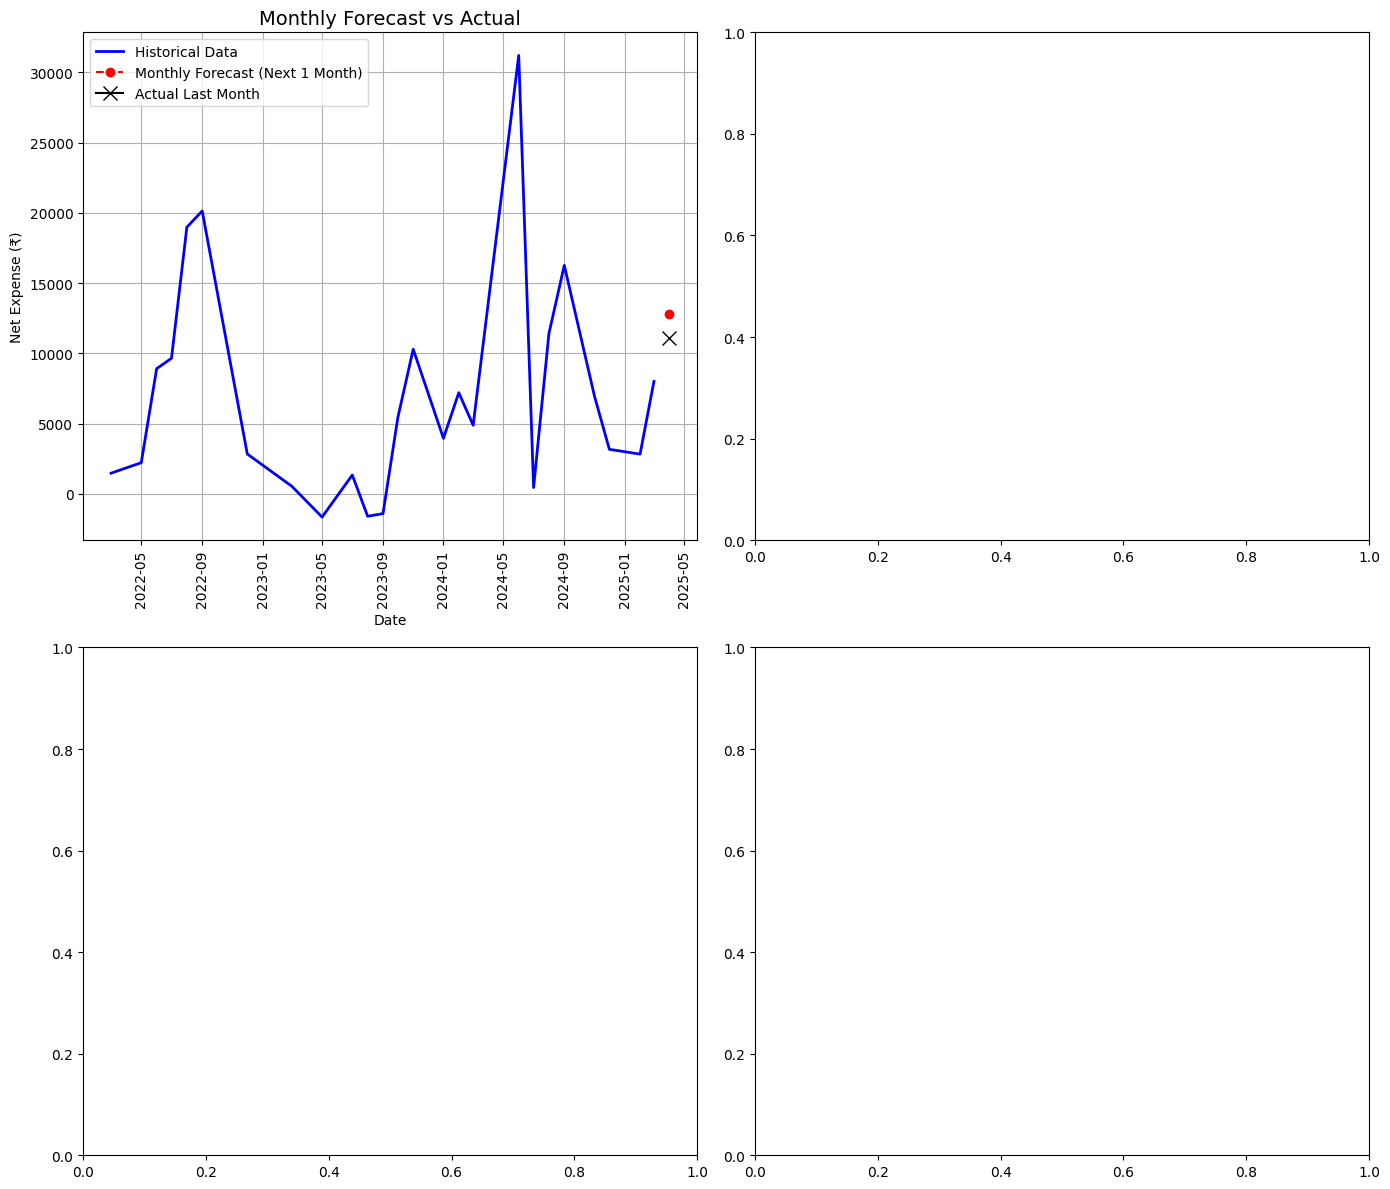

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Exclude the last month (or period) from the data for comparison
train_data = filtered_df.iloc[:-1]  # Remove the last row for training
test_data = filtered_df.iloc[-1:]  # The last month for actual comparison

# Forecast index for the next 1 month (adjust periods as needed)
forecast_index_monthly = pd.date_range(start=train_data.index[-1], periods=2, freq='MS')[1:]

# Use the fitted SARIMAX model to forecast the next 1 month
monthly_forecast = results.forecast(steps=1)  # Forecast only 1 month

# Plot the detailed visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Monthly Forecast Plot (with actual comparison for the last month)
axes[0, 0].plot(train_data.index, train_data['net_expense'], label="Historical Data", color='blue', linewidth=2)
axes[0, 0].plot(forecast_index_monthly, monthly_forecast, label="Monthly Forecast (Next 1 Month)", color='red', linestyle='--', marker='o')

# Highlight the actual last month's value (test data)
axes[0, 0].plot(test_data.index, test_data['net_expense'], label="Actual Last Month", color='black', marker='x', markersize=10)

# Set titles and labels
axes[0, 0].set_title("Monthly Forecast vs Actual", fontsize=14)
axes[0, 0].set_xlabel("Date")
axes[0, 0].set_ylabel("Net Expense (₹)")
axes[0, 0].legend()
axes[0, 0].grid(True)
axes[0, 0].tick_params(axis='x', rotation=90)

# Adjust layout for better view
plt.tight_layout()

# Display the plots
plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


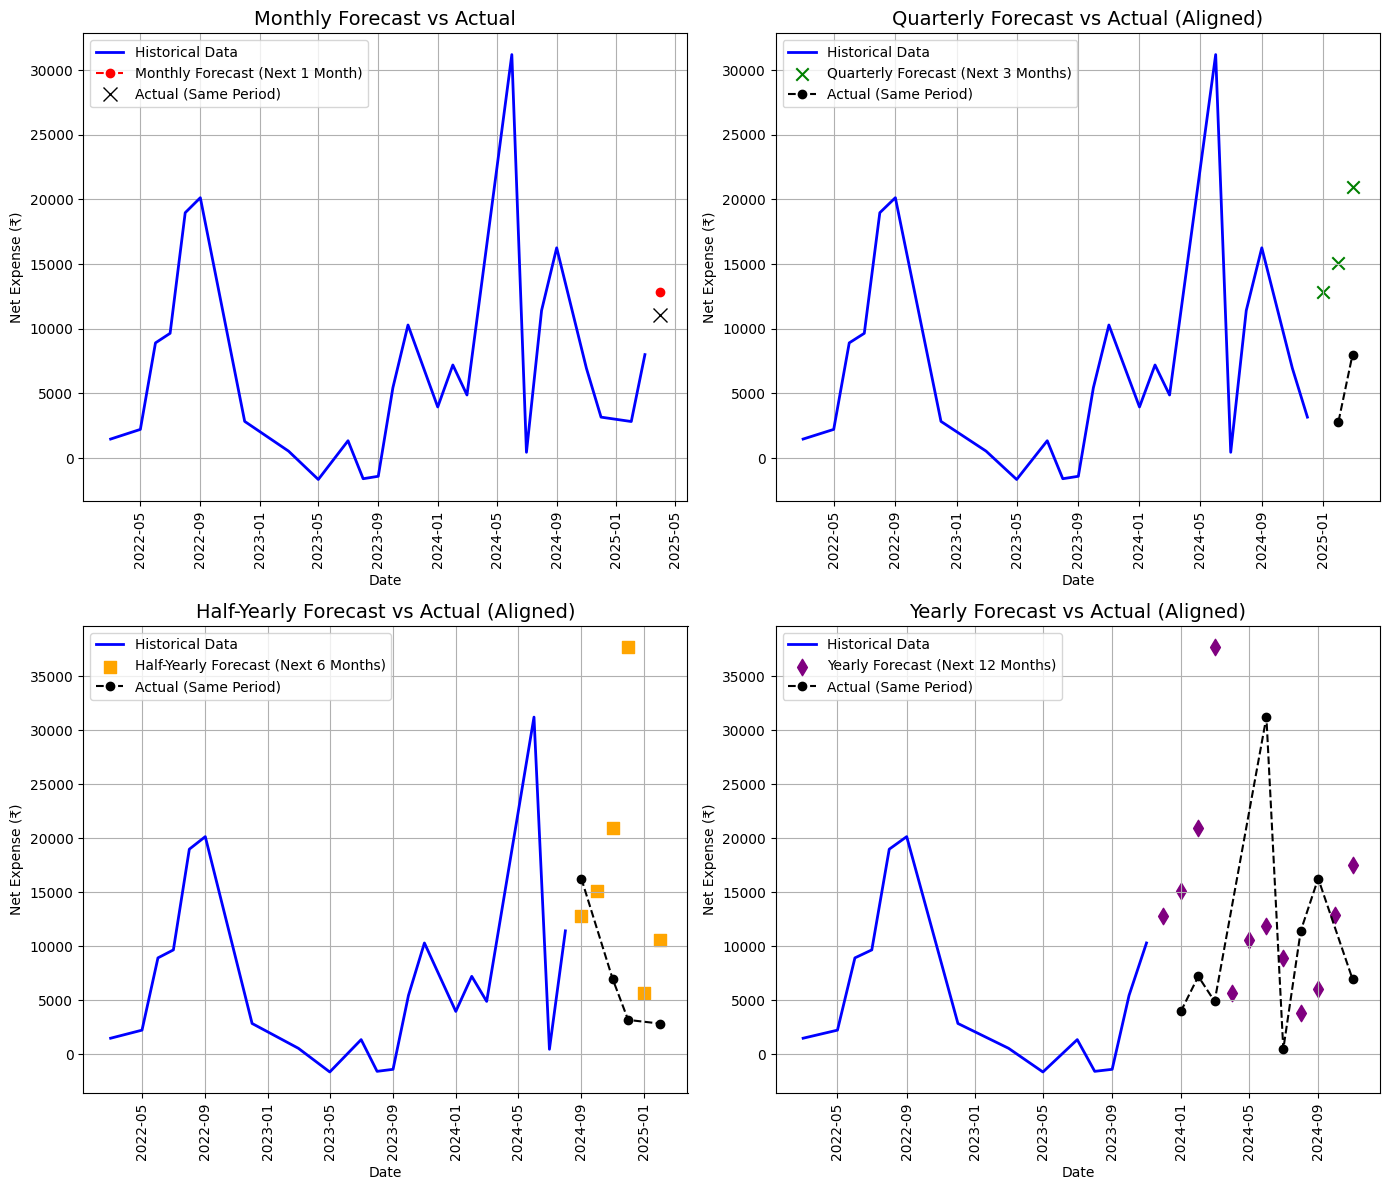

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Forecast index
forecast_index_monthly = pd.date_range(start=filtered_df.index[-2] + pd.DateOffset(months=1), periods=1, freq='MS')
forecast_index_quarterly = pd.date_range(start=filtered_df.index[-4] + pd.DateOffset(months=1), periods=3, freq='MS')
forecast_index_half_yearly = pd.date_range(start=filtered_df.index[-7] + pd.DateOffset(months=1), periods=6, freq='MS')
forecast_index_yearly = pd.date_range(start=filtered_df.index[-13] + pd.DateOffset(months=1), periods=12, freq='MS')

# Forecasts
monthly_forecast = results.forecast(steps=1)
quarterly_forecast = results.forecast(steps=3)
half_yearly_forecast = results.forecast(steps=6)
yearly_forecast = results.forecast(steps=12)

# Actual data for forecast periods (aligned)
actual_data_month = filtered_df.loc[forecast_index_monthly.intersection(filtered_df.index)]
actual_data_quarter = filtered_df.loc[forecast_index_quarterly.intersection(filtered_df.index)]
actual_data_half_year = filtered_df.loc[forecast_index_half_yearly.intersection(filtered_df.index)]
actual_data_year = filtered_df.loc[forecast_index_yearly.intersection(filtered_df.index)]

# Training data (before forecast period)
train_data = filtered_df.iloc[:-1]
train_data_quarter = filtered_df.iloc[:-3]
train_data_half_year = filtered_df.iloc[:-6]
train_data_year = filtered_df.iloc[:-12]

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Monthly Forecast
axes[0, 0].plot(train_data.index, train_data['net_expense'], label="Historical Data", color='blue', linewidth=2)
axes[0, 0].plot(forecast_index_monthly, monthly_forecast, label="Monthly Forecast (Next 1 Month)", color='red', linestyle='--', marker='o')
axes[0, 0].plot(actual_data_month.index, actual_data_month['net_expense'], label="Actual (Same Period)", color='black', marker='x', linestyle='', markersize=10)
axes[0, 0].set_title("Monthly Forecast vs Actual", fontsize=14)
axes[0, 0].set_xlabel("Date")
axes[0, 0].set_ylabel("Net Expense (₹)")
axes[0, 0].legend()
axes[0, 0].grid(True)
axes[0, 0].tick_params(axis='x', rotation=90)

# Quarterly Forecast
axes[0, 1].plot(train_data_quarter.index, train_data_quarter['net_expense'], label="Historical Data", color='blue', linewidth=2)
axes[0, 1].scatter(forecast_index_quarterly, quarterly_forecast, label="Quarterly Forecast (Next 3 Months)", color='green', marker='x', s=80)
axes[0, 1].plot(actual_data_quarter.index, actual_data_quarter['net_expense'], label="Actual (Same Period)", color='black', marker='o', linestyle='--', linewidth=1.5)
axes[0, 1].set_title("Quarterly Forecast vs Actual (Aligned)", fontsize=14)
axes[0, 1].set_xlabel("Date")
axes[0, 1].set_ylabel("Net Expense (₹)")
axes[0, 1].legend()
axes[0, 1].grid(True)
axes[0, 1].tick_params(axis='x', rotation=90)

# Half-Yearly Forecast
axes[1, 0].plot(train_data_half_year.index, train_data_half_year['net_expense'], label="Historical Data", color='blue', linewidth=2)
axes[1, 0].scatter(forecast_index_half_yearly, half_yearly_forecast, label="Half-Yearly Forecast (Next 6 Months)", color='orange', marker='s', s=70)
axes[1, 0].plot(actual_data_half_year.index, actual_data_half_year['net_expense'], label="Actual (Same Period)", color='black', marker='o', linestyle='--', linewidth=1.5)
axes[1, 0].set_title("Half-Yearly Forecast vs Actual (Aligned)", fontsize=14)
axes[1, 0].set_xlabel("Date")
axes[1, 0].set_ylabel("Net Expense (₹)")
axes[1, 0].legend()
axes[1, 0].grid(True)
axes[1, 0].tick_params(axis='x', rotation=90)

# Yearly Forecast
axes[1, 1].plot(train_data_year.index, train_data_year['net_expense'], label="Historical Data", color='blue', linewidth=2)
axes[1, 1].scatter(forecast_index_yearly, yearly_forecast, label="Yearly Forecast (Next 12 Months)", color='purple', marker='d', s=70)
axes[1, 1].plot(actual_data_year.index, actual_data_year['net_expense'], label="Actual (Same Period)", color='black', marker='o', linestyle='--', linewidth=1.5)
axes[1, 1].set_title("Yearly Forecast vs Actual (Aligned)", fontsize=14)
axes[1, 1].set_xlabel("Date")
axes[1, 1].set_ylabel("Net Expense (₹)")
axes[1, 1].legend()
axes[1, 1].grid(True)
axes[1, 1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


1. Forecast the test period

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Assuming you have the actual test data and the forecasted data
# Replace these with actual values from your data and forecast
actual = filtered_df['net_expense'][-len(monthly_forecast):]  # Adjust length based on your forecast
predicted = monthly_forecast  # Use the forecast values you have

# Ensure that the actual and predicted values align in terms of their indices
# You may need to adjust or match the index for both actual and predicted

# Calculate MAE, RMSE, and MAPE for the monthly forecast
mae = mean_absolute_error(actual, predicted)
rmse = np.sqrt(mean_squared_error(actual, predicted))
mape = np.mean(np.abs((actual - predicted) / actual)) * 100

print(f"Monthly Forecast Accuracy:")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")


Monthly Forecast Accuracy:
MAE: 8999.947878346087
RMSE: 9098.873013961831
MAPE: nan%


<ipython-input-39-8c814411fb0b>:15: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((actual - predicted) / actual)) * 100


In [ ]:
# Ensure both actual and predicted are numeric values, not datetime
actual_monthly = filtered_df['net_expense'][-len(monthly_forecast):]
predicted_monthly = monthly_forecast

# Similarly, update other forecasts to handle only numeric values
actual_quarterly = filtered_df['net_expense'][-len(quarterly_forecast):]
predicted_quarterly = quarterly_forecast

actual_half_yearly = filtered_df['net_expense'][-len(half_yearly_forecast):]
predicted_half_yearly = half_yearly_forecast

actual_yearly = filtered_df['net_expense'][-len(yearly_forecast):]
predicted_yearly = yearly_forecast

# Calculate MAE, RMSE, and MAPE for the monthly forecast
mae = mean_absolute_error(actual_monthly, predicted_monthly)
rmse = np.sqrt(mean_squared_error(actual_monthly, predicted_monthly))
mape = np.mean(np.abs((actual_monthly - predicted_monthly) / actual_monthly)) * 100

# Calculate accuracy for quarterly, half-yearly, and yearly forecasts
mae_quarterly = mean_absolute_error(actual_quarterly, predicted_quarterly)
rmse_quarterly = np.sqrt(mean_squared_error(actual_quarterly, predicted_quarterly))
mape_quarterly = np.mean(np.abs((actual_quarterly - predicted_quarterly) / actual_quarterly)) * 100

mae_half_yearly = mean_absolute_error(actual_half_yearly, predicted_half_yearly)
rmse_half_yearly = np.sqrt(mean_squared_error(actual_half_yearly, predicted_half_yearly))
mape_half_yearly = np.mean(np.abs((actual_half_yearly - predicted_half_yearly) / actual_half_yearly)) * 100

mae_yearly = mean_absolute_error(actual_yearly, predicted_yearly)
rmse_yearly = np.sqrt(mean_squared_error(actual_yearly, predicted_yearly))
mape_yearly = np.mean(np.abs((actual_yearly - predicted_yearly) / actual_yearly)) * 100

# Print all metrics
print("Monthly Forecast Accuracy:")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")

print("Quarterly Forecast Accuracy:")
print(f"MAE: {mae_quarterly}")
print(f"RMSE: {rmse_quarterly}")
print(f"MAPE: {mape_quarterly}%")

print("Half-Yearly Forecast Accuracy:")
print(f"MAE: {mae_half_yearly}")
print(f"RMSE: {rmse_half_yearly}")
print(f"MAPE: {mape_half_yearly}%")

print("Yearly Forecast Accuracy:")
print(f"MAE: {mae_yearly}")
print(f"RMSE: {rmse_yearly}")
print(f"MAPE: {mape_yearly}%")


Monthly Forecast Accuracy:
MAE: 8999.947878346087
RMSE: 9098.873013961831
MAPE: nan%
Quarterly Forecast Accuracy:
MAE: 8999.947878346087
RMSE: 9098.873013961831
MAPE: nan%
Half-Yearly Forecast Accuracy:
MAE: 11182.525211107117
RMSE: 16413.710846878937
MAPE: nan%
Yearly Forecast Accuracy:
MAE: 5571.932709800253
RMSE: 6885.546907019921
MAPE: nan%


<ipython-input-41-34a2d1512af4>:18: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((actual_monthly - predicted_monthly) / actual_monthly)) * 100
<ipython-input-41-34a2d1512af4>:23: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape_quarterly = np.mean(np.abs((actual_quarterly - predicted_quarterly) / actual_quarterly)) * 100
<ipython-input-41-34a2d1512af4>:27: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape_half_yearly = np.mean(np.abs((actual_half_yearly - predicted_half_yearly) / actual_half_yearly)) * 100
<ipython-input-41-34a2d1512af4>:31: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape_yearly = np.mean(np.abs((actual_yearly 

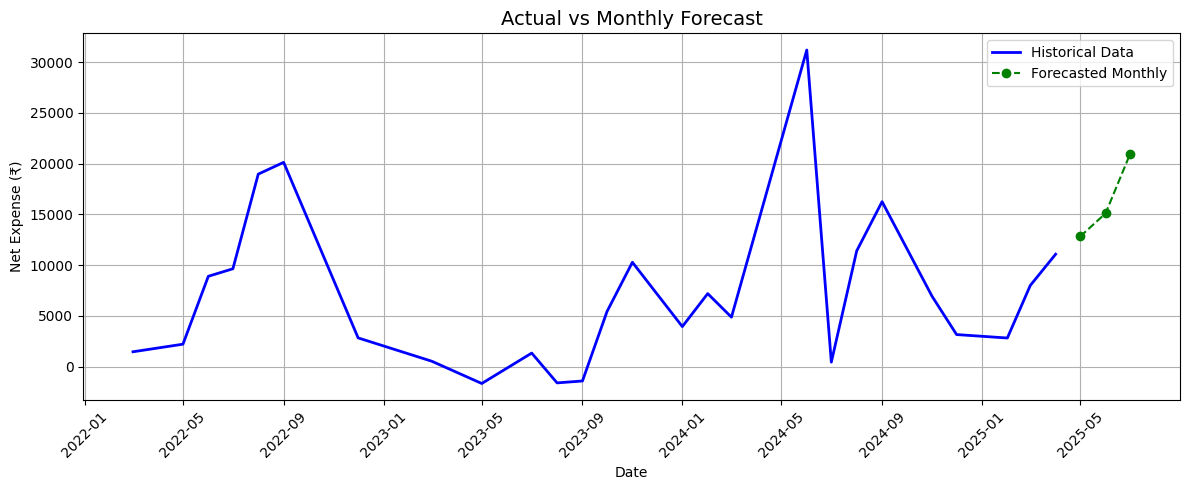

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming filtered_df contains historical data
# Assuming monthly_forecast is the forecast for the next 3 months or so

# Create forecast index for the forecast period
forecast_index_monthly = pd.date_range(start=filtered_df.index[-1], periods=4, freq='MS')[1:]

# Assume test data for the next 3 months (replace with actual data if available)
# For now, let's assume you have actual test data for comparison, e.g., actual_test_monthly
# Example: actual_test_monthly = pd.Series([...], index=forecast_index_monthly)

# Plotting the actual values and forecasted values for comparison
plt.figure(figsize=(12, 5))
plt.plot(filtered_df.index, filtered_df['net_expense'], label='Historical Data', color='blue', linewidth=2)
plt.plot(forecast_index_monthly, monthly_forecast, label='Forecasted Monthly', color='green', linestyle='--', marker='o')

# If you have actual test data, you can plot it as well:
# plt.plot(actual_test_monthly.index, actual_test_monthly, label='Actual Monthly Data', color='orange', linestyle='-', marker='x')

# Title and Labels
plt.title('Actual vs Monthly Forecast', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Net Expense (₹)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()
